In [1]:
from skimage.filters import gaussian
from skimage import color,io, data, exposure, util
## 
import matplotlib.pyplot as plt
import cv2

from skimage.exposure import histogram
from skimage.filters import gaussian
from skimage.filters import threshold_otsu, threshold_local, threshold_li, threshold_minimum
## PIllow
from PIL import Image
import matplotlib.image as mpimg

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise

from skimage.morphology import erosion, dilation, opening, closing, skeletonize

from skimage import transform
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks

from skimage.morphology import skeletonize, thin

## pip install wavelets
my_data = 'M109_M111_021.jpg'


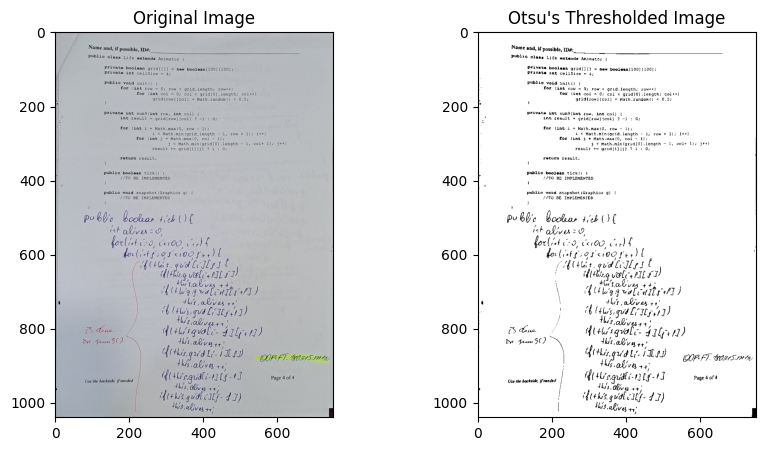

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters

# Load the image
image_path = 'M109_M111_014.jpg'
image = Image.open(image_path)
image = image.rotate(90, expand=True)

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Otsu's thresholding
threshold_value = filters.threshold_otsu(gray_image)
binary_image = gray_image > threshold_value

# Display the original and thresholded images using Matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title("Otsu's Thresholded Image")

plt.savefig('gauss/otsu.png')

plt.show()


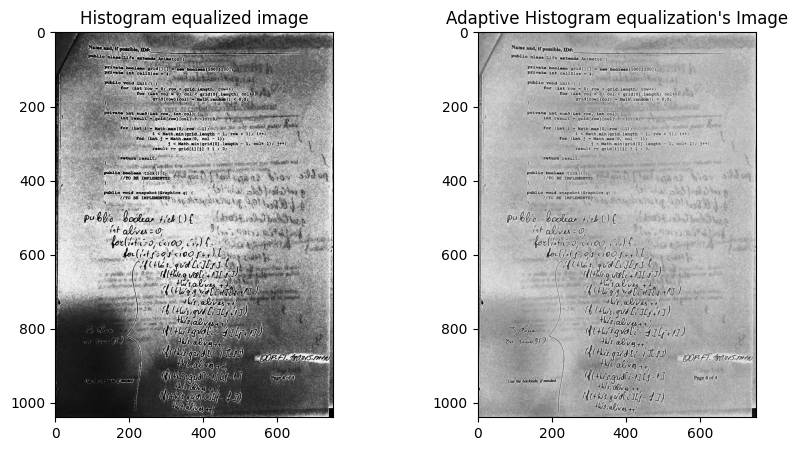

In [3]:
# Convert the image to grayscale
gray_image = color.rgb2gray(image)
img_adapteq = exposure.equalize_adapthist(gray_image, clip_limit=0.03)
img_eq = exposure.equalize_hist(gray_image)
## 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_eq, cmap='gray')
plt.title("Histogram equalized image")

plt.subplot(1, 2, 2)
plt.imshow(img_adapteq, cmap='gray')
plt.title("Adaptive Histogram equalization's Image")

plt.savefig("gauss/histogram_equalized.jpg")

Estimated Gaussian noise standard deviation = 0.07979735960154047


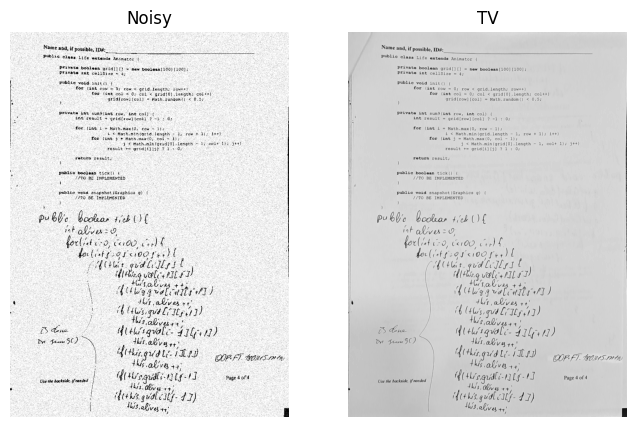

In [4]:


original = np.array(binary_image)
sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0].imshow(noisy)
ax[0].axis('off')
ax[0].set_title('Noisy')

ax[1].imshow(denoise_tv_chambolle(gray_image, weight=0.01, channel_axis=-1))
ax[1].axis('off')
ax[1].set_title('TV')

plt.savefig("gauss/noisytv.jpg")
plt.show()


In [5]:
def im_erosion(image, kernel, n):
    for i in range(n):
        image = erosion(image, kernel)
    return image

def im_closing(image, selem, n):
    for i in range(n):
        image = closing(image,selem)
    return image

def im_opening(image, selem, n):
    for i in range(n):
        image = opening(image,selem)
    return image

kernel = np.array([[0,1,0],
                   [1,1,1],
                   [0,1,0]])


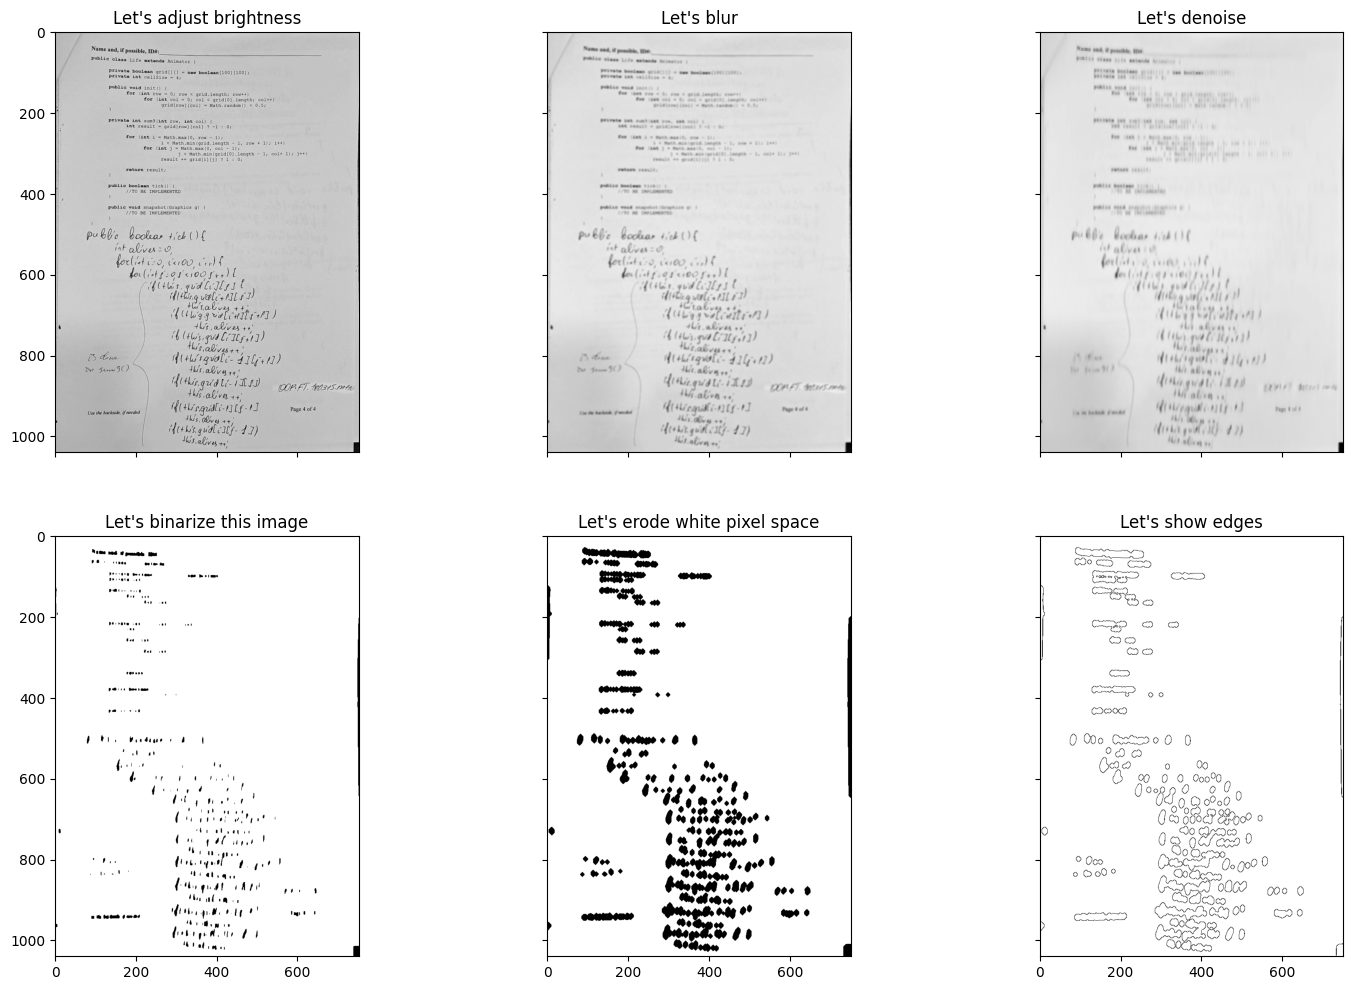

In [6]:
adjusted_image = exposure.adjust_gamma(gray_image, gamma=1.2) 
sigma = 1.7
img_blur = gaussian(adjusted_image, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)
img_denoise = denoise_tv_chambolle(img_blur, weight=0.2, channel_axis=-1)

img_binary = img_denoise > filters.threshold_otsu(gray_image)
img_bold =  im_erosion(img_binary,kernel,5)

# Apply Canny edge detection
edges = canny(img_bold)
edges_i = 1 - edges
# Perform Hough Line Transform
hough_space, angles, distances = hough_line(edges)
# Find peaks in the Hough space
peaks, angles, distances = hough_line_peaks(hough_space, angles, distances)
# Create a blank image to draw the lines
lines_image = np.zeros_like(img_bold)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), sharex=True, sharey=True)

ax[0,0].set_title("Let's adjust brightness")
ax[0,0].imshow(adjusted_image, cmap='gray')

ax[0,1].set_title("Let's blur")
ax[0,1].imshow(img_blur, cmap='gray')

ax[0,2].set_title("Let's denoise")
ax[0,2].imshow(img_denoise, cmap='gray')

ax[1,0].set_title("Let's binarize this image")
ax[1,0].imshow(img_binary, cmap='gray')

ax[1,1].set_title("Let's erode white pixel space")
ax[1,1].imshow(img_bold, cmap='gray')

ax[1,2].set_title("Let's show edges")
ax[1,2].imshow(edges_i)

plt.savefig("gauss/process.png")

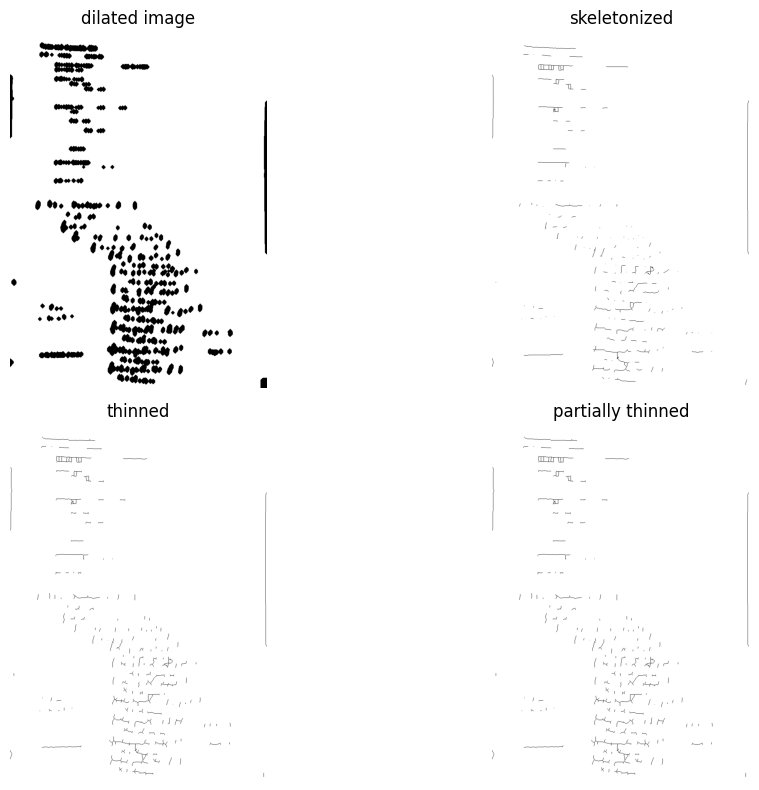

In [7]:
inverted_img = util.invert(img_bold)

skeleton = skeletonize(inverted_img)
thinned = thin(inverted_img)
thinned_partial = thin(inverted_img, max_num_iter=25)

## invert using simpler method
invert_skeleton = 1 - skeleton
invert_thin = 1 - thinned
invert_thin_partial = 1 - thinned_partial
### 
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img_bold, cmap=plt.cm.gray)
ax[0].set_title('dilated image')
ax[0].axis('off')

## 
ax[1].imshow(invert_skeleton, cmap=plt.cm.gray)
ax[1].set_title('skeletonized')
ax[1].axis('off')

## 
ax[2].imshow(invert_thin, cmap=plt.cm.gray)
ax[2].set_title('thinned')
ax[2].axis('off')

## 
ax[3].imshow(invert_thin_partial, cmap=plt.cm.gray)
ax[3].set_title('partially thinned')
ax[3].axis('off')
## 

## 
fig.tight_layout()

plt.savefig("gauss/skeleton.png")
plt.show()

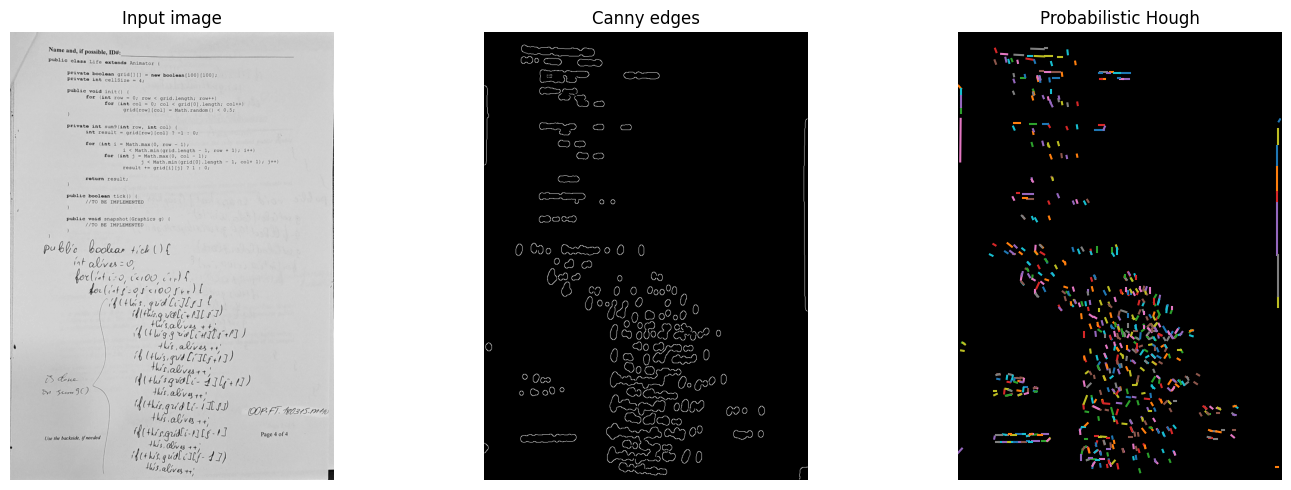

In [8]:
from skimage.transform import probabilistic_hough_line

edges = canny(img_bold, 2, 1, 1)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, gray_image.shape[1]))
ax[2].set_ylim((gray_image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()

plt.savefig("gauss/prob_hough.png")
plt.show()

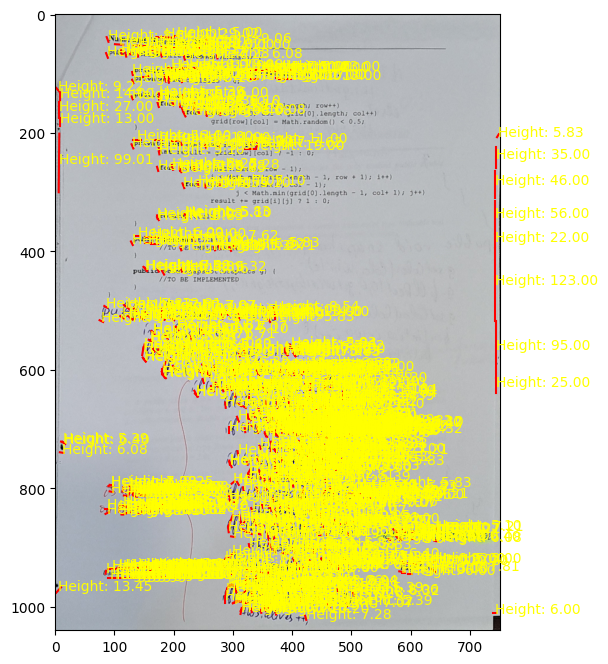

In [23]:
euclidean_distances = [np.sqrt((x1 - x0)**2 + (y1 - y0)**2) for (x0, y0), (x1, y1) in lines]

## MINKOWSKI DISTANCE may be considered as well

# Display the image with detected lines
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap=plt.cm.gray)

# Plot the detected lines on the image
for line, height in zip(lines, euclidean_distances):
    (x0, y0), (x1, y1) = line
    ax.plot((x0, x1), (y0, y1), '-r')
    ax.text((x0 + x1) / 2, (y0 + y1) / 2, f'Height: {height:.2f}', color='yellow')
    #print("height:", height)

plt.savefig("gauss/hough_on_paper_heights.png")
plt.show()

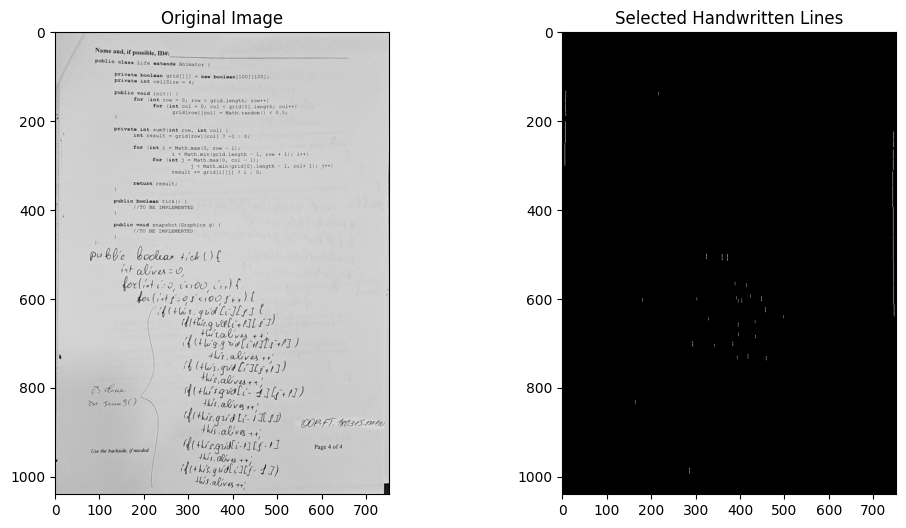

In [24]:

orientation_threshold = np.pi - np.pi/80  # Lines with orientation outside this range will be selected
selected_lines = [line for line in lines if np.abs(np.arctan2(line[1][0] - line[0][0], line[1][1] - line[0][1])) > orientation_threshold]

# Create an image to visualize the selected lines
lines_handwritten_selected = np.zeros_like(gray_image)
# Draw the selected lines on the image
for line in selected_lines:
    rr, cc = np.linspace(line[0][0], line[1][0], num=int(np.sqrt((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2))),np.linspace(line[0][1], line[1][1], num=int(np.sqrt((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2)))
    rr, cc = np.round(rr).astype(int), np.round(cc).astype(int)
    lines_handwritten_selected[cc, rr] = 1
## 
kernel2 = np.array([[0,1,0],[1,1,1],[0,1,0]])
lines_handwritten_selected = im_erosion(lines_handwritten_selected, kernel2, 2)
# Display the image with the selected lines
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Display the original image
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
###  
# Display the image with selected lines
ax[1].imshow(lines_handwritten_selected, cmap=plt.cm.gray)
ax[1].set_title('Selected Handwritten Lines')

plt.savefig("gauss/select_handwritten.png")
plt.show()

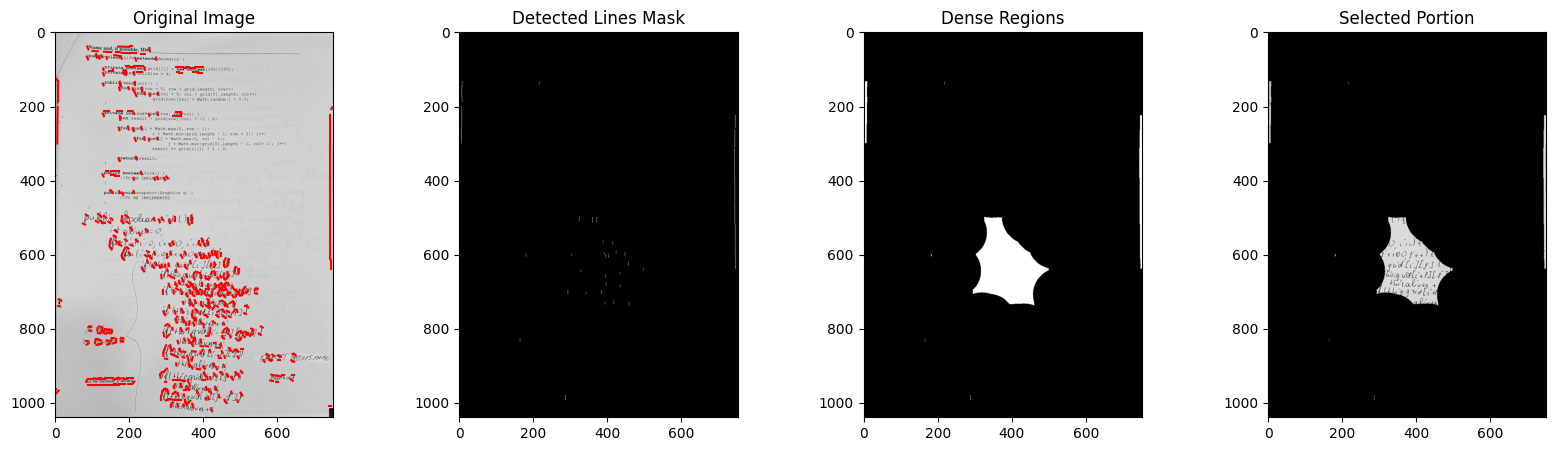

In [21]:
from skimage import io, color, morphology
# Create a binary mask based on the detected lines
#line_mask = np.zeros_like(gray_image, dtype=np.uint8)
#for line in lines:
#    cc, rr = np.linspace(line[0][0], line[1][0], num=int(np.sqrt((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2))),np.linspace(line[0][1], line[1][1], num=int(np.sqrt((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2)))
#    cc, rr = np.round(rr).astype(int), np.round(cc).astype(int)
#    line_mask[cc, rr] = 1

#line_mask = im_opening(line_mask, kernel2, 9)
#kernel2 = np.array([[0,0,0],[0,1,0],[0,0,0]])
#line_mask = im_opening(line_mask, kernel2, 9)
# Use morphological operations to identify dense regions
sigma = 3
lines_handwritten_selected = gaussian(lines_handwritten_selected, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)

dense_regions = morphology.binary_closing(lines_handwritten_selected, morphology.disk(70))
# Select pixels from the original image corresponding to dense regions
selected_portion = gray_image.copy()
selected_portion[~dense_regions] = 0  # Set non-dense regions to zero

# Display the original image, detected lines, dense regions, and the selected portion
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Display the original image
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')

# Draw the detected lines on the original image
for line in lines:
    ax[0].plot( [line[0][0], line[1][0]],[line[0][1], line[1][1]], '-r')
    
# Display the binary mask of detected lines
ax[1].imshow(lines_handwritten_selected, cmap=plt.cm.gray)
ax[1].set_title('Detected Lines Mask')

# Display the dense regions
ax[2].imshow(dense_regions, cmap=plt.cm.gray)
ax[2].set_title('Dense Regions')

# Display the selected portion from the original image
ax[3].imshow(selected_portion)
ax[3].set_title('Selected Portion')

plt.savefig("gauss/portions.png")
plt.show()

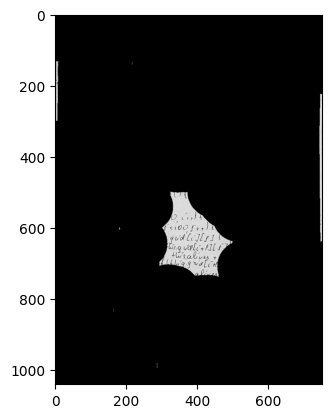

In [22]:
plt.imshow(selected_portion)
plt.savefig("gauss/penalty_portion.png")

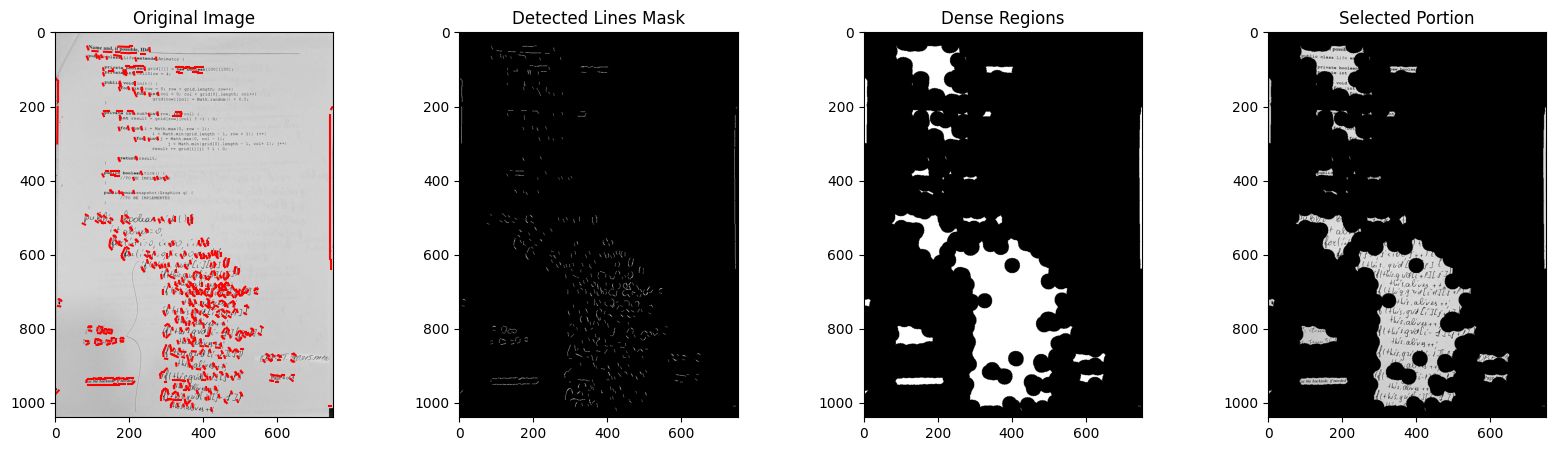

In [27]:
from skimage import io, color, morphology
# Create a binary mask based on the detected lines
line_mask = np.zeros_like(gray_image, dtype=np.uint8)
for line in lines:
    cc, rr = np.linspace(line[0][0], line[1][0], num=int(np.sqrt((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2))),np.linspace(line[0][1], line[1][1], num=int(np.sqrt((line[1][0] - line[0][0])**2 + (line[1][1] - line[0][1])**2)))
    cc, rr = np.round(rr).astype(int), np.round(cc).astype(int)
    line_mask[cc, rr] = 1

#line_mask = im_opening(line_mask, kernel2, 9)
kernel2 = np.array([[0,0,0],[0,1,0],[0,0,0]])
line_mask = im_closing(line_mask, kernel2, 9)
# Use morphological operations to identify dense regions
dense_regions = morphology.binary_closing(line_mask, morphology.disk(20))
# Select pixels from the original image corresponding to dense regions
selected_portion = gray_image.copy()
selected_portion[~dense_regions] = 0  # Set non-dense regions to zero

# Display the original image, detected lines, dense regions, and the selected portion
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Display the original image
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')

# Draw the detected lines on the original image
for line in lines:
    ax[0].plot( [line[0][0], line[1][0]],[line[0][1], line[1][1]], '-r')
    
# Display the binary mask of detected lines
ax[1].imshow(line_mask, cmap=plt.cm.gray)
ax[1].set_title('Detected Lines Mask')

# Display the dense regions
ax[2].imshow(dense_regions, cmap=plt.cm.gray)
ax[2].set_title('Dense Regions')

# Display the selected portion from the original image
ax[3].imshow(selected_portion)
ax[3].set_title('Selected Portion')

plt.savefig("gauss/portions_no_threshold_closing.png")
plt.show()

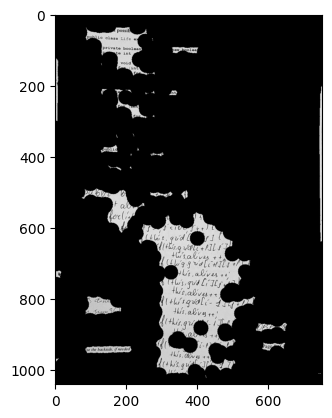

In [13]:
plt.imshow(selected_portion)
plt.savefig("gauss/selected_portion.png")

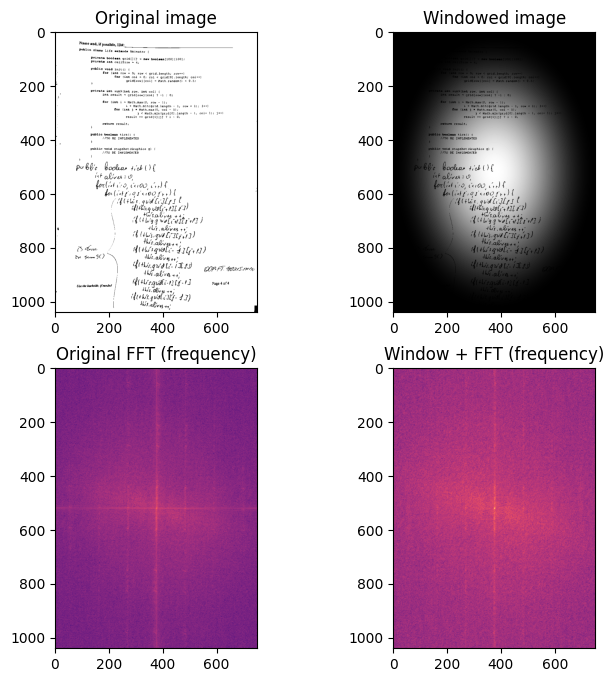

In [30]:
##

from scipy.fft import fft2, fftshift
from skimage import img_as_float
from skimage.color import rgb2gray

from skimage.filters import window
## 
#image = img_as_float(rgb2gray(crop_numeric))
wimage = binary_image * window('hann', binary_image.shape)
image_f = np.abs(fftshift(fft2(binary_image)))  ## image_f retrieve information from this
wimage_f = np.abs(fftshift(fft2(wimage)))

## # 
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()

## 
ax[0].set_title("Original image")
ax[0].imshow(binary_image, cmap='gray')
ax[1].set_title("Windowed image")
ax[1].imshow(wimage, cmap='gray')
ax[2].set_title("Original FFT (frequency)")
ax[2].imshow(np.log(image_f), cmap='magma')
ax[3].set_title("Window + FFT (frequency)")
ax[3].imshow(np.log(wimage_f), cmap='magma')

plt.savefig("gauss/fftshift.png")
plt.show()
## 

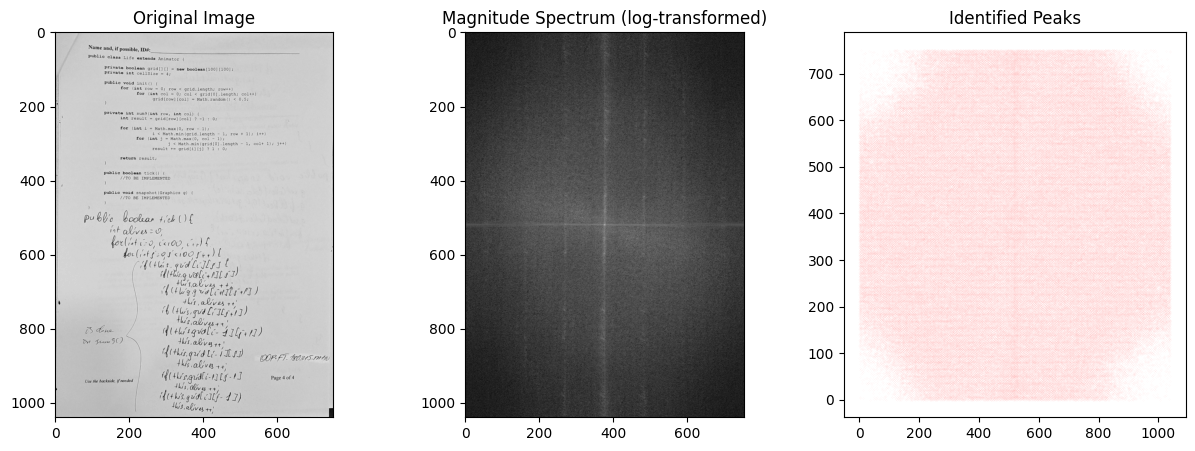

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float

from scipy.signal import find_peaks
# Apply fftshift to bring the zero frequency component to the center
image_fft_shifted = np.abs(fftshift(fft2(gray_image))) 

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(image_fft_shifted)

# Find peaks in the magnitude spectrum
peaks, _ = find_peaks(magnitude_spectrum.ravel(), height=10)  # Adjust height parameter as needed

# Convert 1D indices to 2D coordinates
peaks_2d = np.unravel_index(peaks, magnitude_spectrum.shape)

# Display the original image and magnitude spectrum with identified peaks
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')

# Display the magnitude spectrum
ax[1].imshow(np.log(magnitude_spectrum + 1), cmap=plt.cm.gray)
ax[1].set_title('Magnitude Spectrum (log-transformed)')

# Highlight the identified peaks in the magnitude spectrum
#ax[2].plot(peaks_2d[1], peaks_2d[0], 'ro', markersize=0.01)
##
ax[2].plot(peaks_2d[0], peaks_2d[1], 'ro', markersize=0.01)
ax[2].set_title('Identified Peaks')
# Analyze the identified peaks
#for peak in zip(peaks_2d[0], peaks_2d[1]):
#    print(f"Peak at position: {peak}, Magnitude: {magnitude_spectrum[peak]}")
plt.savefig("gauss/fftpeaks.png")
plt.show()

In [81]:
peaks_2d[1]
#peaks_2d[0]

array([  1,   4,   7, ..., 744, 746, 749], dtype=int64)